# **Imports**

In [6]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functionsML as f
from itertools import combinations
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler

# data partition
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import importlib
importlib.reload(f)

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


### **Import data sets**

In [7]:
train_db = pd.read_csv("./train.csv")
test_db = pd.read_csv("./test.csv")

# **Data exploration**

Our goal here is to understand the data, and the issues that come with it

- Typos in transmission and fuel

- EngineSize with NaN

- Mileage, mpg and previousOwners with irational values

- PreviousOwners with negative values

- hasDamage seems to always be 0

- The categorical variables have a lot of unique values

- Missing values in year mileage tax mpg engineSize paintQuality% previousOwners and hasDamage

- Alarming min values in mileage tax mpg engineSize paintQuality% previousOwners

- Alarming max values in year mpg paintQuality% previousOwners

- HasDamage is always 0

- Year is float64, should be int64

- PreviousOwners is float, should be int64

# **Unique Values**

We wanted to take a better look at what kind of values each variable had, and we ended up finding:

- Typos in every categorical variable

- Different letter casing in every categorical variable

- Unrealistic negative values and irrational values in every numerical category

- There is a strong correlation between mpg's and tax's missing values

# **Distributions & Value Counts**

#### Here we aim to treat the spotted issues, treat outliers and NaN values

In [8]:
# Drop irrelevant column
train_db = train_db.drop(columns="hasDamage")

train_db_numerical = train_db.select_dtypes(exclude=["object"]).columns
# Lowercase text columns
train_db_categorical = train_db.select_dtypes(include=["object"]).columns
train_db[train_db_categorical] = train_db[train_db_categorical].apply(lambda x: x.str.lower() if x.dtype=="object" else x)


# Loop and fix all categorical columns
for col in train_db_categorical:
    train_db = f.fix_typos(col, train_db)

# Rounding future Int values
train_db.loc[:, "year"] = train_db["year"].round()

# Rounds every other irrational number into having one precision digit
for col in train_db.select_dtypes(include="float64").columns:
    # Round each column to 1 digit after the decimal
    train_db[col] = train_db[col].round(1)

### **Outlier treatment**

- We can imideatly spot some issues on the graphs, including absurd values and values that don't make sense

In [9]:
# Removed replace absurd/incorrect values with NaN for them later to be filled
train_db.loc[train_db["mileage"] < 0, "mileage"] = np.nan
train_db.loc[~train_db["tax"].between(0, 400), "tax"] = np.nan
train_db.loc[~train_db["mpg"].between(0, 150), "mpg"] = np.nan
train_db.loc[~train_db["engineSize"].between(1, 6), "engineSize"] = np.nan
train_db.loc[train_db["paintQuality%"] > 100, "paintQuality%"] = np.nan
train_db.loc[~train_db["year"].between(1990, 2020), "year"] = np.nan
train_db.loc[~train_db["previousOwners"].between(0, 4), "previousOwners"] = np.nan


#### Next we apply log(1 + x) transformation to reduce skewness and normalize distribution
#### This will help our model handle right-skewed variables better
#### We will also aplly a clipping cap to the tax's and enfineSize's 1% and 99% in order to reduce the effects of the outliers on the final outcome

In [10]:
train_db['price'] = np.log1p(train_db['price'])
train_db['mileage'] = np.log1p(train_db['mileage'])
train_db['mpg'] = np.log1p(train_db['mpg'])

# Identify lower and upper bounds for the 'tax' feature at the 1st and 99th percentiles
# This is used to remove extreme outliers that could distort the model
tax_lower, tax_upper = train_db['tax'].quantile([0.01, 0.99])

# Clip (cap) 'tax' values to the 1%–99% range to limit outlier influence
train_db['tax'] = train_db['tax'].clip(tax_lower, tax_upper)

# Apply log(1 + x) transformation to 'tax' for normalization
train_db['tax'] = np.log1p(train_db['tax'])

# Do the same outlier clipping process for the 'engineSize' feature
engineSize_lower, engineSize_upper = train_db['engineSize'].quantile([0.01, 0.99])
train_db['engineSize'] = train_db['engineSize'].clip(engineSize_lower, engineSize_upper)


## **Variable Relationships**

### Our goal here is to find the best relationship between variables so we can, more accuratly, fill the missing values

First we tried to find the relation between categorical variables using Cramér's V, but we realized that the variables might be directionally related

In [11]:
cat_cols = train_db.select_dtypes(include=['object']).columns

# Compute Cramér's V between all pairs
for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        v = f.cramers_v(train_db[col1], train_db[col2])
        print(f"Cramér's V between {col1} and {col2}: {v:.3f}")

Cramér's V between Brand and model: 0.995
Cramér's V between Brand and transmission: 0.299
Cramér's V between Brand and fuelType: 0.278
Cramér's V between model and transmission: 0.363
Cramér's V between model and fuelType: 0.489
Cramér's V between transmission and fuelType: 0.199


So we ended up going with a Theil's U directional relationship, while also testing out different variable combinations

In [12]:
num_cols = train_db.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns


# Try single and multi-column combinations up to this size
max_combo_size = 3

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_db[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_db[target], joint_var)
            u_scores[joint_name] = u

    # Pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:

For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.562
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.519

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.326
  U(transmission | model + fuelType) = 0.316
  U(transmission | Brand + model) = 0.291

For categorical column 'fuelType', best predictors:
  U(fuelType | Brand + model + transmission) = 0.403
  U(fuelType | model + transmission) = 0.396
  U(fuelType | Brand + model) = 0.360


- We initially attempted to convert the numerical variables into categorical ones using binning so that they could be included in Theil's U calculation. However, this approach worsened the overall results, so we decided to focus solely on comparing the categorical variables.

We also explored the relationships between numerical target features and the possible combinations of numerical and categorical features. In this case, converting numerical features into bins and mixing them with categorical variables actually produced positive results.

In [13]:
for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_db[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_pair in combinations(cat_cols, num_paired):
            combined = train_db[list(cat_pair)].astype(str).agg('_'.join, axis=1)
            scores[cat_pair] = f.correlation_ratio(combined, train_db[target]) ** 2


    # Mixed numeric + categorical pairs
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_db[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=15, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = f.correlation_ratio(combined, df[target]) ** 2

    # Top 3 helpers 
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")



For numerical column 'year', top helpers (R² or η²):
 ('mileage', 'model') => 0.579
 ('mileage', 'fuelType') => 0.511
 ('mileage', 'Brand') => 0.507

For numerical column 'mileage', top helpers (R² or η²):
 ('year', 'model') => 0.492
 ('year', 'Brand') => 0.456
 ('year', 'fuelType') => 0.454

For numerical column 'tax', top helpers (R² or η²):
 ('year', 'model') => 0.469
 ('mpg', 'model') => 0.438
 ('mpg', 'Brand') => 0.361

For numerical column 'mpg', top helpers (R² or η²):
 ('model', 'fuelType') => 0.556
 ('tax', 'model') => 0.489
 ('engineSize', 'model') => 0.463

For numerical column 'engineSize', top helpers (R² or η²):
 ('mpg', 'model') => 0.787
 ('tax', 'model') => 0.737
 ('model', 'fuelType') => 0.726

For numerical column 'paintQuality%', top helpers (R² or η²):
 ('mileage', 'model') => 0.021
 ('year', 'model') => 0.015
 ('previousOwners', 'model') => 0.011

For numerical column 'previousOwners', top helpers (R² or η²):
 ('paintQuality%', 'model') => 0.024
 ('mileage', 'mode

## **Filling in missing values**

In [14]:
# Safely convert previousOwners and year to nullable integers
train_db["previousOwners"] = pd.to_numeric(train_db["previousOwners"], errors='coerce').round().astype("Int64")
train_db["year"] = pd.to_numeric(train_db["year"], errors='coerce').round().astype("Int64")

# Handle Brand for i3
idx_to_drop = train_db[(train_db['model'] == 'i3') & (train_db['Brand'].isna())].index
train_db = train_db.drop(idx_to_drop)

# Fill categorical columns
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "mpg", ["model","fuelType"])
train_db["transmission"] = train_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_db["fuelType"] = train_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
train_db = f.fill_NaN_with_mixed(train_db, "year", "model", "mileage")
train_db = f.fill_NaN_with_mixed(train_db, "mileage", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "tax", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "engineSize", "model", "tax")

# Fill numeric columns with median
train_db["paintQuality%"] = train_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
train_db["previousOwners"] = train_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Drop any remaining NaNs
train_db = train_db.dropna()


- Now no variable has missing values

# **Feature Selection**

- year and mileage have a strong relationship
- and so does tax and pmg
- both paintQuality% and previousOwners seem to have little correlation with every variable

We need to encode categorical variables into numericals, and we decided to encode Brand transmission and fuelType with one-hot encoding, and we also created a Brand_model_encoded where, using kfold traget encode, we can achieve a numerical model without having to worry about different brands having models with the same name

In [15]:
one_hot = pd.get_dummies(train_db["Brand"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot], axis=1)

train_db['transmission'] = train_db['transmission'].replace('other', 'unknown')

one_hot2 = pd.get_dummies(train_db["transmission"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot2], axis=1)

train_db["fuelType"] = train_db["fuelType"].replace('other', 'electric')

one_hot3 = pd.get_dummies(train_db["fuelType"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot3], axis=1)

train_db = f.kfold_target_encode(train_db, cat_cols=['Brand','model'], target_col='price', n_splits=5)

We split the dataframe into two groups, one to train the model, and the other to validate it

In [16]:
X = train_db.drop(columns=["price","carID"])
y = train_db["price"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  shuffle = True)

X has the numeric variables extracted and scaled

In [17]:
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)

# repeat for val

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)

In [18]:
scaler = MinMaxScaler()

#fit to training data
scaler.fit(X_train_num)

#transform the data
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)


#show results
X_train_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,bmw,ford,hyundai,...,skoda,toyota,vw,manual,semi-auto,unknown,electric,hybrid,petrol,Brand_model_encoded
49782,0.833333,0.771881,0.533617,0.789973,0.00,0.363450,0.25,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.460868
72756,0.791667,0.833015,0.890623,0.722420,0.20,0.609856,0.50,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.390708
14648,0.833333,0.799564,0.890623,0.718810,0.50,0.815195,0.00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.549204
65927,0.958333,0.723917,0.873482,0.780581,0.30,0.527721,0.25,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.511118
22160,0.958333,0.704811,0.873482,0.789973,0.00,0.804928,0.50,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.462162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21265,0.625000,0.893916,0.873482,0.766597,0.50,0.445585,0.50,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.573826
45954,0.958333,0.690935,0.879384,0.789973,0.00,0.353183,1.00,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.460087
42670,0.625000,0.671780,0.873482,0.729973,0.25,0.897331,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.584011
43625,0.958333,0.649454,0.873482,0.726479,0.50,0.661191,0.75,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.546122


Checking the categorical variables correlation with the target

In [19]:
for var in X_train_cat:
    f.TestCorrelationRatio(X_train_cat[var],y_train, var)

Brand is IMPORTANT for prediction (η = 0.569)
model is IMPORTANT for prediction (η = 0.755)
transmission is IMPORTANT for prediction (η = 0.567)
fuelType is IMPORTANT for prediction (η = 0.254)


Calculated the optimal number of features for a Linear Regression

In [20]:
#no of features
nof_list=np.arange(1,len(X_train_num_scaled.columns)+1)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 19
Score with 19 features: 0.894657


In [21]:
model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 19)

train_db_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)

rfe.support_

array([ True,  True, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [22]:
X_train_num_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'bmw', 'ford', 'hyundai', 'mercedes', 'opel', 'skoda',
       'toyota', 'vw', 'manual', 'semi-auto', 'unknown', 'electric', 'hybrid',
       'petrol', 'Brand_model_encoded'],
      dtype='object')

In [23]:
rfe.ranking_

array([1, 1, 2, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [24]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

year                    True
mileage                 True
tax                    False
mpg                     True
engineSize              True
paintQuality%          False
previousOwners         False
bmw                     True
ford                    True
hyundai                 True
mercedes                True
opel                    True
skoda                   True
toyota                  True
vw                      True
manual                  True
semi-auto               True
unknown                 True
electric                True
hybrid                  True
petrol                  True
Brand_model_encoded     True
dtype: bool

Check the feature importance with the LassoCV

In [25]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_num_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 21 variables and eliminated the other 1 variables


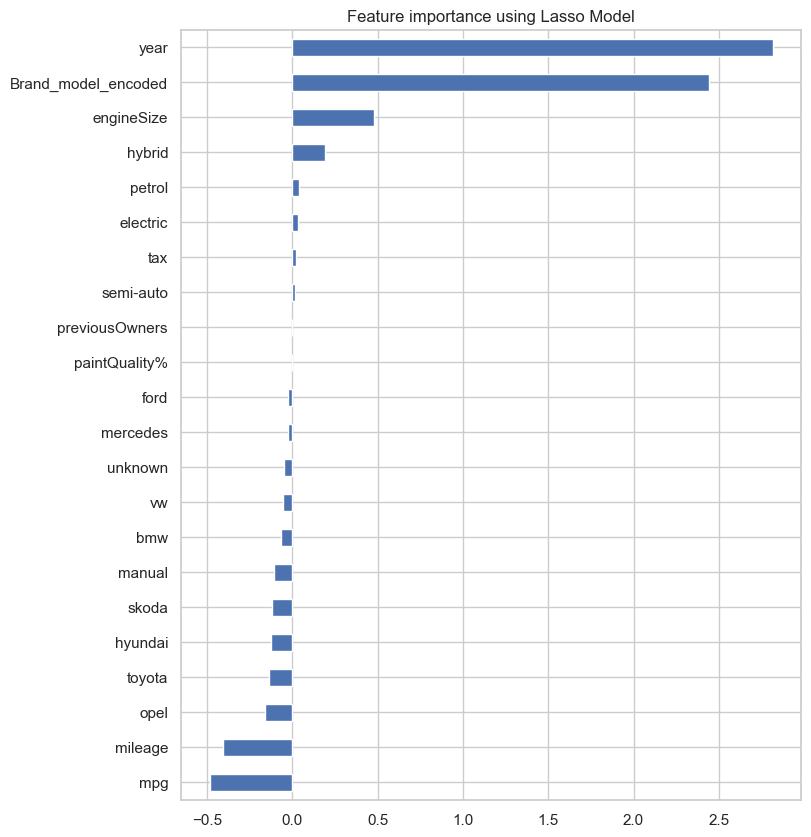

In [26]:
plot_importance(coef,'Lasso')

<hr>

### Numerical Data

| Predictor | Pearson | RFE LR| Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |---|
| year | Keep? | Keep | Keep | Include in the model |
| engineSize | Keep | Keep |Keep| Include in the model |
| tax | Keep?| Discard? | Discard | Try with and without |
| previousOwners | Keep? | Discard | Discard | Discard |
| paintQuality% | Keep? | Discard | Discard | Discard |
| mpg | Keep? | Keep | Keep? | Try with and without |
| mileage | Keep? | Keep | Keep | Keep |

<hr>


### Categorical Data

| Predictor | Correlation Ratio | 
| --- | --- | 
| Brand | Keep |  
|  model | Keep | 
| transmission | Keep |
| fuelType| Keep? |


<hr>



After testing out different combinations, we came to the conclusion that dropping previousOwners and paintQuality% had the best return

In [27]:
X_train_num_scaled = X_train_num_scaled.drop(columns=['previousOwners', "paintQuality%"])

X_val_num_scaled = X_val_num_scaled.drop(columns=['previousOwners', "paintQuality%"])

perguntar ao professor mesmo se knn nao se pode usar as variaveis categoricas emsmo depois de transformadas em numericas, porque da melhor resultado no entanto o chat gpt diz que nao se deva variaveis categoricas mesmo depois ... antes estava r2 0.93 e depois 0.85

Tipo de dado         	Métrica recomendada
Numérico contínuo,escalado	                  euclidean ou minkowski (p=2)
Numérico com outliers	                      manhattan ou chebyshev
Dados normalizados entre 0 e 1	                euclidean ou cosine
Dados correlacionados ou com escalas diferentes	                  mahalanobis
Alta dimensionalidade, direção importa (ex: embeddings)	            cosine

In [28]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


X_train_num_scaled_import = X_train_num_scaled[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
X_val_num_scaled_import   = X_val_num_scaled[['year', 'mileage', 'tax', 'mpg', 'engineSize']]


# 1. Definir o Modelo KNN
# Começamos com um k=5 padrão, mas isso pode ser otimizado
knn_model = KNeighborsRegressor(n_neighbors=10, metric='manhattan', n_jobs=-1)

# 2. Treinar o Modelo
# Nota: Usamos os dados ESCALONADOS (scaled), isso é obrigatório para o KNN
knn_model.fit(X_train_num_scaled_import, y_train)

# 3. Prever nos dados de validação
y_pred_knn = knn_model.predict(X_val_num_scaled_import)

# 4. Avaliar o Modelo
print("--- Resultados Iniciais do KNN (k=5) ---")
print(f"R²: {r2_score(y_val, y_pred_knn):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_knn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_knn)):.2f}")




--- Resultados Iniciais do KNN (k=5) ---
R²: 0.864
MAE: 0.14
RMSE: 0.20


In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Definir o modelo
knn = KNeighborsRegressor(n_jobs=-1)

# 2. Definir os parâmetros a testar
# Testamos K, as Métricas e os Pesos ao mesmo tempo
param_grid = {
    'n_neighbors': range(1, 31),  # Testar K de 1 a 30
    'weights': ['uniform', 'distance'], # Testar com e sem pesos por distância
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'] # Principais métricas
}

# 3. Configurar a busca (Grid Search)
# cv=5 significa que ele valida 5 vezes para ter certeza que o resultado é sólido
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# 4. Treinar
print("Procurando os melhores hiperparâmetros...")
grid_search.fit(X_train_num_scaled_import, y_train)

# 5. Resultados
best_model = grid_search.best_estimator_
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

# 6. Avaliação Final na Validação
pred = best_model.predict(X_val_num_scaled_import)
rmse = np.sqrt(mean_squared_error(y_val, pred))
print(f"R²: {r2_score(y_val, pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred)):.2f}")

Procurando os melhores hiperparâmetros...
Melhores parâmetros encontrados: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
R²: 0.866
MAE: 0.14
RMSE: 0.19


A treinar a Rede Neuronal...
Epoch 1/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.2753 - mae: 1.1548 - val_loss: 1.0686 - val_mae: 1.0046
Epoch 2/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4431 - mae: 0.5053 - val_loss: 2.6381 - val_mae: 1.6015
Epoch 3/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1726 - mae: 0.3081 - val_loss: 1.3605 - val_mae: 1.1404
Epoch 4/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0927 - mae: 0.2250 - val_loss: 0.7872 - val_mae: 0.8575
Epoch 5/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0579 - mae: 0.1790 - val_loss: 0.4479 - val_mae: 0.6360
Epoch 6/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0465 - mae: 0.1601 - val_loss: 0.3470 - val_mae: 0.5505
Epoch 7/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0423 - mae: 0.1524 - val_loss: 0.2629 - val_mae: 0.4732
Epoch 8/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0401 - mae: 0.1481 - val_loss: 0.3021 - val_mae: 0.5105
Epo

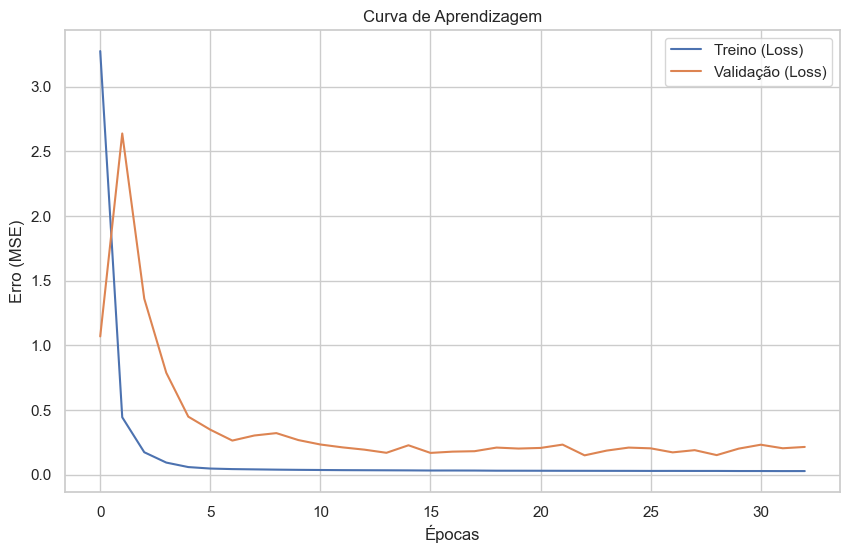

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1. Definir a Arquitetura da Rede
# Input shape é o número de colunas (features) que temos
input_shape = [X_train_num_scaled.shape[1]]

model = keras.Sequential([
    # Primeira camada oculta com 64 neurónios e ativação ReLU
    layers.Dense(64, activation='relu', input_shape=input_shape),
    # Dropout ajuda a prevenir overfitting desligando 20% dos neurónios aleatoriamente
    layers.Dropout(0.2),
    
    # Segunda camada oculta
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Terceira camada oculta (opcional, para mais complexidade)
    layers.Dense(16, activation='relu'),
    
    # Camada de Saída: 1 único neurónio para prever o preço (valor contínuo)
    layers.Dense(1)
])

# 2. Compilar o Modelo
# 'adam' é um otimizador excelente e versátil
# 'mae' (Mean Absolute Error) é uma boa métrica de perda para preços
model.compile(
    optimizer='adam',
    loss='mean_squared_error', # Usamos MSE para guiar o treino (penaliza grandes erros)
    metrics=['mae']
)

# 3. Configurar Paragem Antecipada (Early Stopping)
# Se o modelo parar de melhorar na validação, paramos o treino para não decorar os dados
early_stopping = EarlyStopping(
    min_delta=0.001, # Mínima melhoria considerada
    patience=10,     # Quantas épocas esperar sem melhoria antes de parar
    restore_best_weights=True
)

# 4. Treinar a Rede
print("A treinar a Rede Neuronal...")
history = model.fit(
    X_train_num_scaled, y_train,
    validation_data=(X_val_num_scaled, y_val),
    batch_size=32, # Quantos carros analisa de cada vez antes de atualizar pesos
    epochs=100,    # Máximo de passagens pelos dados
    callbacks=[early_stopping],
    verbose=1 # Mostra a barra de progresso
)

# 5. Avaliar o Desempenho
y_pred_nn = model.predict(X_val_num_scaled)

print("\n--- Resultados da Rede Neuronal ---")
print(f"R²: {r2_score(y_val, y_pred_nn):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_nn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_nn)):.2f}")

# 6. Gráfico de Aprendizagem (Loss Curve)
# Isto mostra se o modelo estava a aprender bem ou a decorar (overfitting)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Treino (Loss)')
plt.plot(history.history['val_loss'], label='Validação (Loss)')
plt.title('Curva de Aprendizagem')
plt.xlabel('Épocas')
plt.ylabel('Erro (MSE)')
plt.legend()
plt.grid(True)
plt.show()

A treinar o MLPRegressor...
Iteration 1, loss = 186489220.25262943
Validation score: -2.354540
Iteration 2, loss = 128740235.48030615
Validation score: -0.631737
Iteration 3, loss = 58289019.49890503
Validation score: 0.022900
Iteration 4, loss = 43284521.93330474
Validation score: 0.169634
Iteration 5, loss = 37183973.20051689
Validation score: 0.268339
Iteration 6, loss = 33116812.47611535
Validation score: 0.332564
Iteration 7, loss = 30682575.58079872
Validation score: 0.369304
Iteration 8, loss = 29310213.17095272
Validation score: 0.391490
Iteration 9, loss = 28355726.19436792
Validation score: 0.409678
Iteration 10, loss = 27487918.52054519
Validation score: 0.427063
Iteration 11, loss = 26606392.36727836
Validation score: 0.444955
Iteration 12, loss = 25686675.78099160
Validation score: 0.463677
Iteration 13, loss = 24727461.80057759
Validation score: 0.482846
Iteration 14, loss = 23713587.50570764
Validation score: 0.503600
Iteration 15, loss = 22661950.32198142
Validation sco

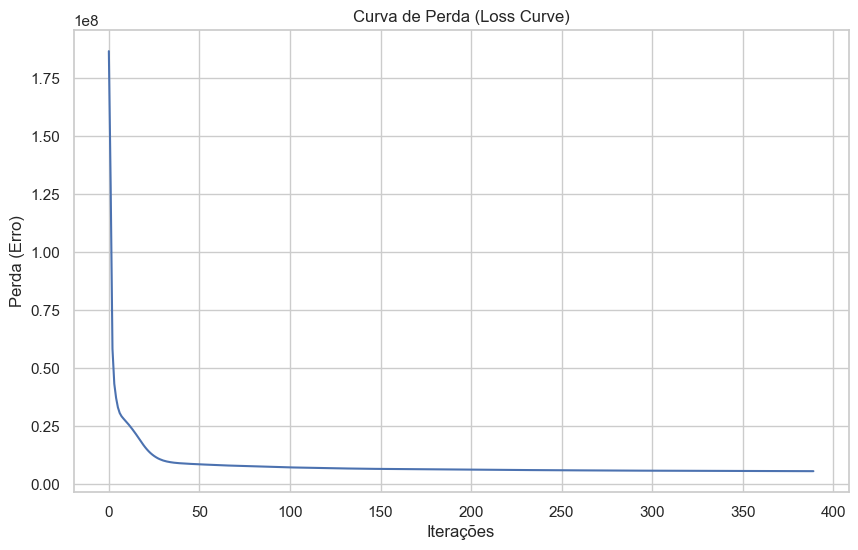


--- Resultados do MLPRegressor ---
R²: 0.867
MAE: 2025.01
RMSE: 3438.57


In [51]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Definir a Rede Neuronal (MLPRegressor)
# De acordo com a aula, definimos as camadas ocultas. 
# Vamos tentar uma configuração "Média/Forte": 2 camadas com 100 e 50 neurónios.
# 'max_iter' define quantas vezes a rede vê os dados.
# 'early_stopping' pára o treino se não houver melhorias (evita overfitting).
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    early_stopping=True, 
    random_state=42,
    verbose=True # Para ver o progresso como no notebook da aula
)

# 2. Treinar o Modelo
print("A treinar o MLPRegressor...")
mlp_model.fit(X_train_num_scaled, y_train)

# 3. Visualizar a Curva de Aprendizagem (Igual à aula)
# Isto mostra como o erro diminuiu ao longo das iterações
plt.figure(figsize=(10, 6))
losses = mlp_model.loss_curve_
iterations = range(mlp_model.n_iter_)
sns.lineplot(x=iterations, y=losses)
plt.title('Curva de Perda (Loss Curve)')
plt.xlabel('Iterações')
plt.ylabel('Perda (Erro)')
plt.grid(True)
plt.show()

# 4. Avaliação
y_pred_mlp = mlp_model.predict(X_val_num_scaled)

print("\n--- Resultados do MLPRegressor ---")
print(f"R²: {r2_score(y_val, y_pred_mlp):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_mlp):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_mlp)):.2f}")

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Definir a Grelha Expandida (Baseada na Aula)
# Adicionámos 'sgd' e 'learning_rate' para testar o que foi dado na aula
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 50, 25)], # Arquiteturas simples vs profundas
    'activation': ['relu', 'tanh'],                    # Funções de ativação
    'solver': ['adam', 'lbfgs', 'sgd'],                # ADICIONADO: 'sgd' como na aula
    'learning_rate': ['constant', 'adaptive'],         # ADICIONADO: Estratégia de aprendizagem
    'alpha': [0.0001, 0.05],                           # Regularização
    'max_iter': [1000]                                 # Garantir tempo para convergência
}

# 2. Configurar e Treinar
mlp = MLPRegressor(random_state=42)
grid_search_nn = GridSearchCV(mlp, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

print("A executar GridSearch (incluindo SGD e Adam)...")
grid_search_nn.fit(X_train_num_scaled, y_train)

# 3. Melhor Modelo
best_nn = grid_search_nn.best_estimator_
print(f"Melhores Parâmetros: {grid_search_nn.best_params_}")

# --- PARTE NOVA: O GRÁFICO DA AULA ---

# O 'lbfgs' não gera loss_curve_ porque não é iterativo da mesma forma.
# Se o melhor modelo for 'adam' ou 'sgd', podemos plotar a curva.
if best_nn.solver in ['adam', 'sgd']:
    plt.figure(figsize=(10, 6))
    # Recuperar a história da perda (erro) ao longo das iterações
    loss_values = best_nn.loss_curve_
    plt.plot(loss_values, label='Training Loss')
    plt.title(f'Curva de Aprendizagem (Loss Curve) - Solver: {best_nn.solver}')
    plt.xlabel('Iterações')
    plt.ylabel('Loss (Erro)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"A rede convergiu após {best_nn.n_iter_} iterações.")
else:
    print(f"O solver vencedor foi '{best_nn.solver}', que não gera curva de perda iterativa (é analítico).")

# Avaliação Final
y_pred_nn = best_nn.predict(X_val_num_scaled)
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
print(f"RMSE Final: {np.sqrt(mean_squared_error(y_val, y_pred_nn)):.2f}")
print(f"R² Final: {r2_score(y_val, y_pred_nn):.3f}")

a partir de para baixo ja é do ricardo 

In [31]:
# 3. Fit model
model = LinearRegression()
model.fit(X_train_num_scaled, y_train)

# 4. Predict
y_pred = model.predict(X_val_num_scaled)

# 5. Evaluate
print(f"R²: {r2_score(y_val, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.2f}")

R²: 0.895
MAE: 0.12
RMSE: 0.17


Now we apply all the methods we analysed to the Linear Regression model

In [32]:
# Drop irrelevant column
test_db = test_db.drop(columns="hasDamage")

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Loop and fix all categorical columns (if your fix_typos function works for test set)
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)

# Apply the same filtering rules
test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
test_db.loc[~test_db["tax"].between(0, 400), "tax"] = np.nan
test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
test_db.loc[~test_db["engineSize"].between(1, 6), "engineSize"] = np.nan
test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan
test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan
test_db.loc[~test_db["previousOwners"].between(0, 4), "previousOwners"] = np.nan



# Apply the same transformations
test_db['mileage'] = np.log1p(test_db['mileage'])
test_db['mpg'] = np.log1p(test_db['mpg'])

# Use the SAME clipping bounds from training data
test_db['tax'] = test_db['tax'].clip(tax_lower, tax_upper)
test_db['tax'] = np.log1p(test_db['tax'])

# Use the SAME clipping bounds from training data  
test_db['engineSize'] = test_db['engineSize'].clip(engineSize_lower, engineSize_upper)

# Rounding future Int values
test_db.loc[:, "year"] = test_db["year"].round()

# Remove negative/irrational previousOwners
test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats to 1 digit
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Remove paintQuality% above 100
test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan

# Remove negative values from numeric columns
for col in test_db.select_dtypes(include="float64").columns:
    test_db = f.negative_to_nan_columns(col, test_db)

# Safely convert previousOwners and year to nullable integers
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# Fill categorical columns using the same functions as training
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")


# Fill numeric columns with median
test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')

for col in numeric_cols:
    # Convert to float to safely handle NaNs and group means
    test_db[col] = test_db[col].astype(float)
    
    # Compute model mean
    category_means = test_db.groupby("model")[col].transform('median')
    
    # Fill NaNs with category mean
    test_db[col] = test_db[col].fillna(category_means)
    
    # Fill any remaining NaNs with global mean
    global_mean = test_db[col].mean()
    test_db[col] = test_db[col].fillna(global_mean)
    
    # Optional: convert back to integer if column was originally integer
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")



        
# One-hot encode categorical columns
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

# Merge rare transmission values
test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

# Merge rare fuelType values
test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)


# Create mapping dictionary from training data using both Brand and model
mapping = (
    train_db
    .set_index(["Brand", "model"])["Brand_model_encoded"]
    .to_dict()
)

# Compute global mean for unseen Brand-model pairs
global_mean = train_db["Brand_model_encoded"].median()

# Map test_df (Brand, model) pairs to encoded values
test_db["Brand_model_encoded"] = (
    test_db[["Brand", "model"]]
    .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1)
)


# Prepare features (exclude price and ID if present)
X_test = test_db.drop(columns=["carID"], errors='ignore')  # ignore if price not in test
X_test_num = X_test.select_dtypes(include=np.number).set_index(X_test.index)

# Scale using the same scaler fitted on training data
X_test_num_scaled = scaler.transform(X_test_num)

X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns).set_index(X_test.index)

X_test_num_scaled = X_test_num_scaled.drop(columns=[ 'previousOwners', "paintQuality%"])

In [33]:
y_test_pred = model.predict(X_test_num_scaled)

# Add predictions to the test DataFrame
test_db['price'] = np.expm1(y_test_pred)

# Create a new DataFrame with only carID and predicted price
submission = test_db[['carID', 'price']].copy()

# Save to CSV
submission.to_csv("predicted_prices.csv", index=False)


# **Random Forest**

### **Import data sets**

In [34]:
train_db = pd.read_csv("./train.csv")
test_db = pd.read_csv("./test.csv")

# **Fixing issues**

In [35]:
# Drop irrelevant column
train_db = train_db.drop(columns="hasDamage")

train_db_numerical = train_db.select_dtypes(exclude=["object"]).columns
# Lowercase text columns
train_db_categorical = train_db.select_dtypes(include=["object"]).columns
train_db[train_db_categorical] = train_db[train_db_categorical].apply(lambda x: x.str.lower() if x.dtype=="object" else x)


# Loop and fix all categorical columns
for col in train_db_categorical:
    train_db = f.fix_typos(col, train_db)

# Rounding future Int values
train_db.loc[:, "year"] = train_db["year"].round()

# Rounds every other irrational number into having one precision digit
for col in train_db.select_dtypes(include="float64").columns:
    # Round each column to 1 digit after the decimal
    train_db[col] = train_db[col].round(1)

### **Outlier treatment**

Since we are using Random Forest here, after some tests, we concluded that it is best to leave every value in, even if absurd

## **Variable Relationships**

This segment follow the same exact logic as the linear regression

### Our goal here is to find the best relationship between variables so we can, more accuratly, fill the missing values

First we tried to find the relation between categorical variables using Cramér's V, but we realized that the variables might be directionally related

In [36]:
num_cols = train_db.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns


# Try single and multi-column combinations up to this size
max_combo_size = 3

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_db[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_db[target], joint_var)
            u_scores[joint_name] = u

    # Pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:

For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.562
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.519

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.326
  U(transmission | model + fuelType) = 0.316
  U(transmission | Brand + model) = 0.291

For categorical column 'fuelType', best predictors:
  U(fuelType | Brand + model + transmission) = 0.403
  U(fuelType | model + transmission) = 0.396
  U(fuelType | Brand + model) = 0.360


- We initially attempted to convert the numerical variables into categorical ones using binning so that they could be included in Theil's U calculation. However, this approach worsened the overall results, so we decided to focus solely on comparing the categorical variables.

We also explored the relationships between numerical target features and the possible combinations of numerical and categorical features. In this case, converting numerical features into bins and mixing them with categorical variables actually produced positive results.

In [37]:
for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_db[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_pair in combinations(cat_cols, num_paired):
            combined = train_db[list(cat_pair)].astype(str).agg('_'.join, axis=1)
            scores[cat_pair] = f.correlation_ratio(combined, train_db[target]) ** 2


    # Mixed numeric + categorical pairs
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_db[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=15, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = f.correlation_ratio(combined, df[target]) ** 2

    # Top 3 helpers 
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")



For numerical column 'year', top helpers (R² or η²):
 ('mileage', 'model') => 0.546
 ('tax', 'model') => 0.487
 ('mileage', 'fuelType') => 0.470

For numerical column 'mileage', top helpers (R² or η²):
 ('year', 'engineSize') => 0.457
 ('year', 'model') => 0.455
 ('year', 'previousOwners') => 0.451

For numerical column 'tax', top helpers (R² or η²):
 ('year', 'model') => 0.471
 ('mpg', 'model') => 0.384
 ('mileage', 'model') => 0.341

For numerical column 'mpg', top helpers (R² or η²):
 ('model', 'fuelType') => 0.667
 ('engineSize', 'fuelType') => 0.497
 ('engineSize', 'model') => 0.438

For numerical column 'engineSize', top helpers (R² or η²):
 ('tax', 'model') => 0.696
 ('mpg', 'model') => 0.678
 ('model', 'fuelType') => 0.663

For numerical column 'paintQuality%', top helpers (R² or η²):
 ('previousOwners', 'model') => 0.013
 ('tax', 'model') => 0.012
 ('mileage', 'model') => 0.012

For numerical column 'previousOwners', top helpers (R² or η²):
 ('paintQuality%', 'model') => 0.02

## **Filling in missing values**

In [38]:
# Safely convert previousOwners and year to nullable integers
train_db["previousOwners"] = pd.to_numeric(train_db["previousOwners"], errors='coerce').round().astype("Int64")
train_db["year"] = pd.to_numeric(train_db["year"], errors='coerce').round().astype("Int64")

# Handle Brand for i3
idx_to_drop = train_db[(train_db['model'] == 'i3') & (train_db['Brand'].isna())].index
train_db = train_db.drop(idx_to_drop)

# Fill categorical columns
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "mpg", ["model","fuelType"])
train_db["transmission"] = train_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_db["fuelType"] = train_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
train_db = f.fill_NaN_with_mixed(train_db, "year", "model", "mileage")
train_db = f.fill_NaN_with_mixed(train_db, "mileage", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "tax", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "engineSize", "model", "tax")

# Fill numeric columns with median
train_db["paintQuality%"] = train_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
train_db["previousOwners"] = train_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Drop any remaining NaNs
train_db = train_db.dropna()


# **Feature Selection**

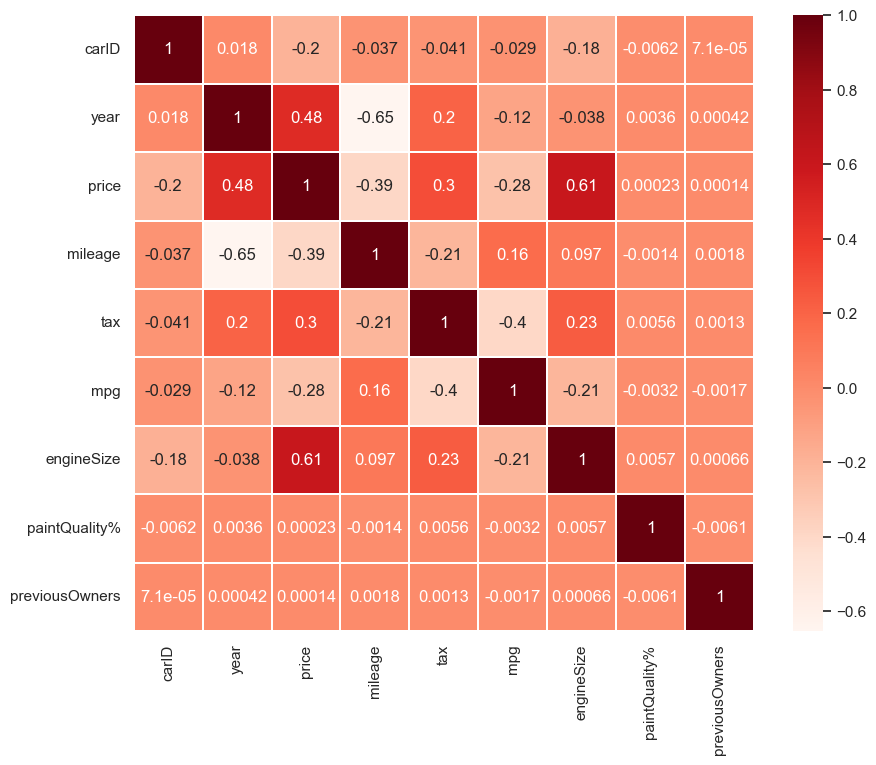

In [39]:
# Remove rows with missing values
temp = train_db.dropna()

# Select numerical columns for correlation analysis
corr_data = temp.select_dtypes(include=["number"])

# Compute the Pearson correlation matrix
correlation_matrix = corr_data.corr(method="pearson")

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap = plt.cm.Reds, linewidths=0.1)
plt.show()

- year and mileage have a strong relationship
- and so does tax and pmg
- both paintQuality% and previousOwners seem to have little correlation with every variable

In [40]:
one_hot = pd.get_dummies(train_db["Brand"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot], axis=1)

train_db['transmission'] = train_db['transmission'].replace('other', 'unknown')

one_hot2 = pd.get_dummies(train_db["transmission"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot2], axis=1)

train_db["fuelType"] = train_db["fuelType"].replace('other', 'electric')

one_hot3 = pd.get_dummies(train_db["fuelType"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot3], axis=1)

train_db = f.kfold_target_encode(train_db, cat_cols=['Brand','model'], target_col='price', n_splits=5)

In [41]:
X = train_db.drop(columns=["price","carID"])
y = train_db["price"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  shuffle = True)

In [42]:
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)

# repeat for val

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)


In [43]:
scaler = MinMaxScaler()

#fit to training data
scaler.fit(X_train_num)

#transform the data
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)


#show results
X_train_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,bmw,ford,hyundai,...,skoda,toyota,vw,manual,semi-auto,unknown,electric,hybrid,petrol,Brand_model_encoded
9755,0.833333,0.253694,0.322009,0.194282,0.328358,0.446774,0.750,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.273483
7670,0.907407,0.159403,0.351810,0.177557,0.164179,0.430645,0.625,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.160889
27365,0.870370,0.179484,0.351810,0.173084,0.238806,0.503226,0.500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.124938
46630,0.925926,0.161295,0.351810,0.149747,0.462687,0.753226,0.750,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.271596
7887,0.907407,0.181495,0.351810,0.184364,0.223881,0.591935,0.250,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.078819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21245,0.870370,0.183523,0.180450,0.206534,0.313433,0.591935,0.500,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.098932
45900,0.888889,0.215811,0.351810,0.180863,0.313433,0.430645,0.625,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.140887
42619,0.870370,0.214196,0.351810,0.212174,0.253731,0.470968,0.750,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.087135
43574,0.870370,0.275482,0.180450,0.215286,0.313433,0.608065,0.250,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161609


In [44]:
for var in X_train_cat:
    f.TestCorrelationRatio(X_train_cat[var],y_train, var)

Brand is IMPORTANT for prediction (η = 0.537)
model is IMPORTANT for prediction (η = 0.761)
transmission is IMPORTANT for prediction (η = 0.542)
fuelType is IMPORTANT for prediction (η = 0.205)


In [45]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_num_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 22 variables and eliminated the other 0 variables


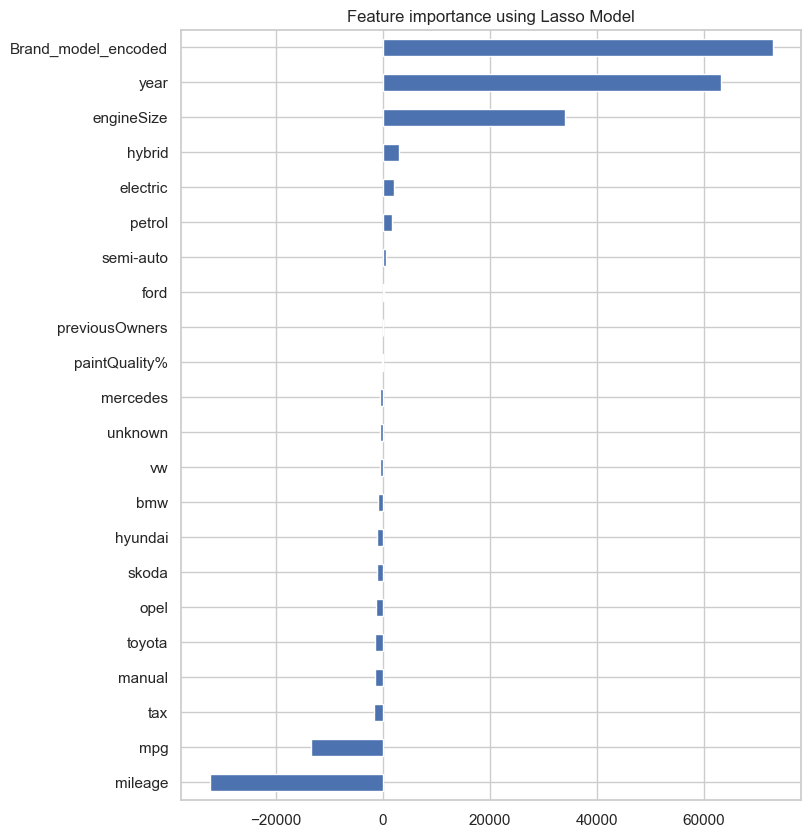

In [46]:
plot_importance(coef,'Lasso')

<hr>

### Numerical Data

| Predictor | Pearson | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |
| year | Keep? | Keep | Include in the model |
| engineSize | Keep |Keep| Include in the model |
| tax | Keep? | Discard | Try with and without |
| previousOwners | Keep? | Discard | Discard |
| paintQuality% | Keep? | Discard | Discard |
| mpg | Keep?  | Keep? | Try with and without |
| mileage | Keep | Keep | Keep |

<hr>


### Categorical Data

| Predictor | Correlation Ratio | 
| --- | --- | 
| Brand | Keep |  
|  model | Keep | 
| transmission | Keep |
| fuelType| Keep? |


<hr>




Even though we are using a random forest here, we still applied the same feature selection methods as in linear regression, and it ended up performing better than using all the features

In [47]:
X_train_num = X_train_num.drop(columns=['previousOwners', "paintQuality%"])

X_val_num = X_val_num.drop(columns=['previousOwners', "paintQuality%"])

The n_estimators was tested through trial and error

In [48]:
model = RandomForestRegressor(
    n_estimators=70,   # number of trees
    random_state=42,
    n_jobs=-1           
)
model.fit(X_train_num, y_train)

# 4. Predict
y_pred = model.predict(X_val_num)

# 5. Evaluate
print(f"R²: {r2_score(y_val, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.2f}")

R²: 0.938
MAE: 1336.35
RMSE: 2350.33


Now we apply all the methods we analysed to the Random Forest model

In [49]:
# Drop irrelevant column
test_db = test_db.drop(columns="hasDamage")

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Loop and fix all categorical columns (if your fix_typos function works for test set)
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)


# Rounding future Int values
test_db.loc[:, "year"] = test_db["year"].round()

# Remove negative/irrational previousOwners
#test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats to 1 digit
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Remove paintQuality% above 100
#test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan

# Remove negative values from numeric columns
for col in test_db.select_dtypes(include="float64").columns:
    test_db = f.negative_to_nan_columns(col, test_db)

# Safely convert previousOwners and year to nullable integers
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# Fill categorical columns using the same functions as training
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

# Fill numeric columns with median
test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')

for col in numeric_cols:
    # Convert to float to safely handle NaNs and group means
    test_db[col] = test_db[col].astype(float)
    
    # Compute model mean
    category_means = test_db.groupby("model")[col].transform('median')
    
    # Fill NaNs with category mean
    test_db[col] = test_db[col].fillna(category_means)
    
    # Fill any remaining NaNs with global mean
    global_mean = test_db[col].median()
    test_db[col] = test_db[col].fillna(global_mean)
    
    # Optional: convert back to integer if column was originally integer
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")



        
# One-hot encode categorical columns
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

# Merge rare transmission values
test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

# Merge rare fuelType values
test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)


# Create mapping dictionary from training data using both Brand and model
mapping = (
    train_db
    .set_index(["Brand", "model"])["Brand_model_encoded"]
    .to_dict()
)

# Compute global mean for unseen Brand-model pairs
global_mean = train_db["Brand_model_encoded"].median()

# Map test_df (Brand, model) pairs to encoded values
test_db["Brand_model_encoded"] = (
    test_db[["Brand", "model"]]
    .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1)
)

# Prepare features (exclude price and ID if present)
X_test = test_db.drop(columns=["carID"], errors='ignore')  # ignore if price not in test
X_test_num = X_test.select_dtypes(include=np.number).set_index(X_test.index)

X_test_num= X_test_num.drop(columns=[ 'previousOwners', "paintQuality%"])

In [50]:
y_test_pred = model.predict(X_test_num_scaled)

# Add predictions to the test DataFrame
#test_db['price'] = np.expm1(y_test_pred)
test_db['price'] = (y_test_pred)

# Create a new DataFrame with only carID and predicted price
submission = test_db[['carID', 'price']].copy()

# Save to CSV
submission.to_csv("predicted_prices.csv", index=False)
